<a href="https://colab.research.google.com/github/simon-mellergaard/GAI-with-LLMs/blob/main/Project%20codes/Assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2


> *Perform the fine-tuning exercise from Chapter 6 in Hands-on Generative AI with Transformers with Transformers and Diffusion Models, but use HuggingFaceTB/SmolLM2-135M instead.  
The goal is to tweak tuning parameters to get healthy looking training-validation curves and reasonable sounding output. Show examples of each from two selected training runs: One that shows warnings signs and one that shows the desired behavior.*

## Setup

Loading libraries, logging, setting device.

In [2]:
# If on kaggle:
#!pip install transformers==4.56.1
# !pip install datasets==4.0.0

In [3]:
# Logging in to Huggingface and wandb
import os
from google.colab import userdata
from huggingface_hub import login as login_hf
from wandb import login as login_wandb
os.environ['HF_TOKEN'] = userdata.get('HF')
os.environ['WANDB_TOKEN'] = userdata.get('wandb')
login_hf(os.environ['HF_TOKEN'])
login_wandb(key = os.environ['WANDB_TOKEN'])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: simonmellergaard (simonmellergaard-aarhus-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
# Libraries
import torch

# Functions
from datasets import load_dataset
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import Trainer

2025-09-18 13:43:18.031844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758202998.222111      76 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758202998.276208      76 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Setting up the device (GPU). Code is taken from the genaibook-module.
def get_device(cuda_ordinal=None):
    if torch.cuda.is_available():
        return torch.device("cuda", cuda_ordinal)
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()

## Creating a robust text-generation model

The code is based on chapter 6 from the Hands-on book. It will fine-tune a model for text generation. This will still use the ag-news dataset

In [6]:
raw_datasets = load_dataset("ag_news")
raw_datasets

filtered_datasets = raw_datasets.filter(lambda example: example["label"] == 2)
filtered_datasets = filtered_datasets.remove_columns("label")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7600 [00:00<?, ? examples/s]

The model to be used is [SmolLM v2](https://huggingface.co/HuggingFaceTB/SmolLM2-135M). This model is loaded, and the datset is tokenized.

In [7]:
model_id = "HuggingFaceTB/SmolLM2-135M"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = (
    tokenizer.eos_token
)
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

# Tokenizing
def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized_datasets = filtered_datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],  # We only need the input_ids and attention_mask
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1900 [00:00<?, ? examples/s]

Data collator.

In [8]:
from transformers import DataCollatorForLanguageModeling

# mlm corresponds to masked language modeling
# and we set it to False as we are not training a masked language model
# but a causal language model
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

The training arguments for the model is defined, and passed into the actual trainer. The training arguments has been modified to get a model that performs reasonable.

In [9]:
training_args = TrainingArguments(
    "business-news-generator-smollm2",
    push_to_hub=True,
    per_device_train_batch_size=8,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    num_train_epochs=2,
    eval_strategy="steps",
    eval_steps=200,
    logging_steps=200,
)

In [10]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"].select(range(5000)),
    eval_dataset=tokenized_datasets["test"],
)

/tmp/ipykernel_76/2651450017.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


The model is trained:

In [11]:
train_result = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
200,3.182100,3.396496
400,2.912200,3.303886
600,2.710700,3.172083
800,1.671700,3.252725
1000,1.478600,3.228773
1200,1.417500,3.216723


The training-validation loss curves should be evaluated for the model.

In [ ]:
    plt.plot(epochs, train_loss, 'o-', label='Training Loss', color = 'purple')
    plt.plot(epochs, val_loss, 'o-', label='Validation Loss', color = 'navy')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [80]:
history = trainer.state.log_history[:-1]
results = pd.DataFrame(columns=pd.DataFrame(history).columns)
for i in range(len(history)):
    if i % 2 == 0:
        # Add a new row
        new_row = pd.DataFrame(history[i], index=[0])
        results = pd.concat([results, new_row], ignore_index=True)
    else:
        # Get keys
        cols = history[i].keys()
        # Find the number of rows in results
        row = len(results) - 1
        # Add data
        results.loc[row, cols] = history[i]

/tmp/ipykernel_76/706772683.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,3.1821,2.824802,0.000469,0.32,200.0,3.396496,11.5554,164.425,20.596
1,2.9122,2.646894,0.000384,0.64,400.0,3.303886,11.5814,164.056,20.55
2,2.7107,2.998789,0.000266,0.96,600.0,3.172083,11.6382,163.256,20.45
3,1.6717,2.571766,0.000144,1.28,800.0,3.252725,11.5683,164.242,20.574
4,1.4786,2.036341,0.000048,1.60,1000.0,3.228773,11.6587,162.968,20.414
5,1.4175,3.058030,0.000002,1.92,1200.0,3.216723,11.6263,163.422,20.471


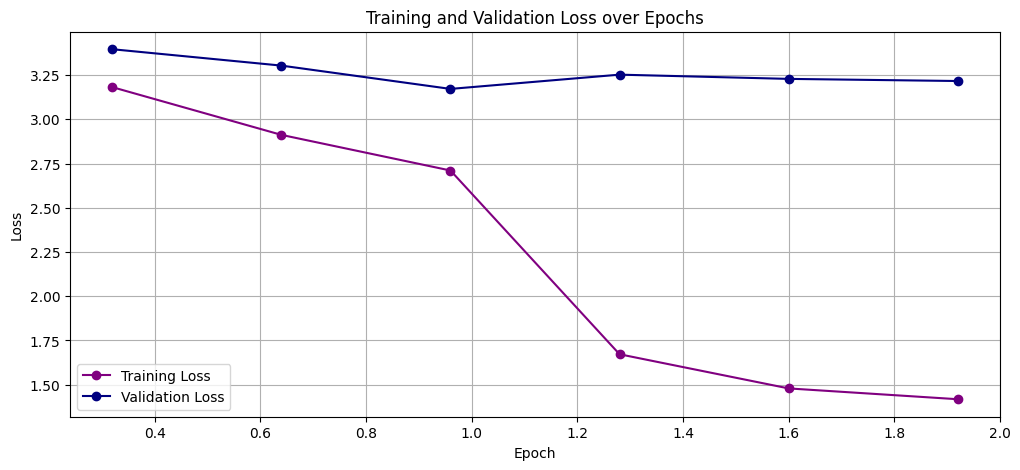

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(results['epoch'], results['loss'], marker='o', label='Training Loss', color = 'purple')
plt.plot(results['epoch'], results['eval_loss'], marker='o', label='Validation Loss', color = 'navy')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()